# 14-8. 프로젝트: 인물 모드 문제점 찾기

### **Step 1. 인물모드 직접 해 보기**

---

- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 보기
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 보기
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경합성을 시도

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib     # 웹에서 데이터 다운 패키지

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
me_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/me.jpg'
me2_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/me2.jpg'
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'

me_img_orig = cv2.imread(me_img_path)
me2_img_orig = cv2.imread(me2_img_path)
cat_img_orig = cv2.imread(cat_img_path)

print (me_img_orig.shape)
print (me2_img_orig.shape)
print (cat_img_orig.shape)

(2048, 1536, 3)
(2048, 1536, 3)
(601, 616, 3)


* 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들기

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# 다운 받은 deeplab model 불러오기

model_dir = '~/aiffel/human_segmentation/models'
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')

MODEL = DeepLabModel(download_path)

* 첫 단계에서 준비한 이미지를 네트워크에 입력

In [5]:
# img_orig : 원본 사진 이미지
# seg_map : 물체로 인식된 라벨 값

me_img_resized, me_seg_map = MODEL.run(me_img_orig)

print (me_img_orig.shape, me_img_resized.shape, me_seg_map.max())

(2048, 1536, 3) (513, 384, 3) 15


In [6]:
me2_img_resized, me2_seg_map = MODEL.run(me2_img_orig)

print (me2_img_orig.shape, me2_img_resized.shape, me2_seg_map.max())

(2048, 1536, 3) (513, 384, 3) 15


In [7]:
cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)

print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max())

(601, 616, 3) (500, 513, 3) 8


* 라벨 정의(사람 = 15, 고양이 = 8)

In [8]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

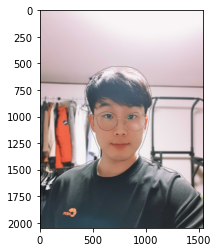

In [10]:
# 1. 내 사진 아웃 포커싱
me_img_show = me_img_resized.copy()
me_seg_map = np.where(me_seg_map == 15, 15, 0) # 예측 중 사람만 추출
me_img_mask = me_seg_map * (255/me_seg_map.max()) # 255 normalization
me_img_mask = me_img_mask.astype(np.uint8)
me_color_mask = cv2.applyColorMap(me_img_mask, cv2.COLORMAP_JET)
me_img_show = cv2.addWeighted(me_img_show, 0.6, me_color_mask, 0.35, 0.0)


me_img_mask_up = cv2.resize(me_img_mask, me_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, me_img_mask_up = cv2.threshold(me_img_mask_up, 128, 255, cv2.THRESH_BINARY)

me_img_mask_color = cv2.cvtColor(me_img_mask_up, cv2.COLOR_GRAY2BGR)
me_img_bg_mask = cv2.bitwise_not(me_img_mask_color)
me_img_bg = cv2.bitwise_and(me_img_orig, me_img_bg_mask)

me_img_bg_blur = cv2.blur(me_img_bg, (13,13))
plt.imshow(cv2.cvtColor(me_img_bg_blur, cv2.COLOR_BGR2RGB))

me_img_concat = np.where(me_img_mask_color==255, me_img_orig, me_img_bg_blur)
plt.imshow(cv2.cvtColor(me_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

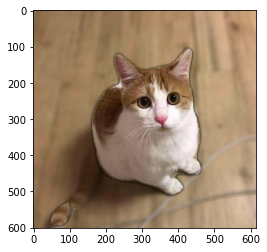

In [11]:
# 2. 고양이 아웃 포커싱
cat_img_show = cat_img_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0) # 예측 중 고양이만 추출
cat_img_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)


cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg = cv2.bitwise_and(cat_img_orig, cat_img_bg_mask)

cat_img_bg_blur = cv2.blur(cat_img_bg, (13,13))
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))

cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
# 3. 크로마키 배경합성

# 배경 이미지 불러오기
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg.jpg'
bg_img_orig = cv2.imread(bg_img_path)
print(bg_img_orig.shape)

# 합성할 원본 이미지 크기에 맞게 배경이미지 사이즈 변경
bg_img_mask_up = cv2.resize(bg_img_orig, me_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

print(bg_img_mask_up.shape)

(400, 600, 3)
(2048, 1536, 3)


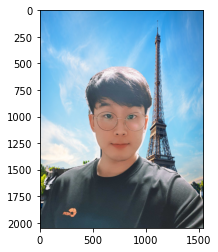

In [18]:
# 합성
me_img_show = me_img_resized.copy()
me_seg_map = np.where(me_seg_map == 15, 15, 0) # 예측 중 사람만 추출
me_img_mask = me_seg_map * (255/me_seg_map.max()) # 255 normalization
me_img_mask = me_img_mask.astype(np.uint8)
me_color_mask = cv2.applyColorMap(me_img_mask, cv2.COLORMAP_JET)
me_img_show = cv2.addWeighted(me_img_show, 0.6, me_color_mask, 0.35, 0.0)


me_img_mask_up = cv2.resize(me_img_mask, me_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, me_img_mask_up = cv2.threshold(me_img_mask_up, 128, 255, cv2.THRESH_BINARY)

me_img_mask_color = cv2.cvtColor(me_img_mask_up, cv2.COLOR_GRAY2BGR)
me_img_bg_mask = cv2.bitwise_not(me_img_mask_color)
me_img_bg = cv2.bitwise_and(me_img_orig, me_img_bg_mask)

me_img_bg_blur = cv2.blur(me_img_bg, (13,13))
plt.imshow(cv2.cvtColor(me_img_bg_blur, cv2.COLOR_BGR2RGB))

me_img_concat = np.where(me_img_mask_color==255, me_img_orig, bg_img_mask_up)
plt.imshow(cv2.cvtColor(me_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### **Step 2. 사진에서 문제점 찾기**

---

그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur돠지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

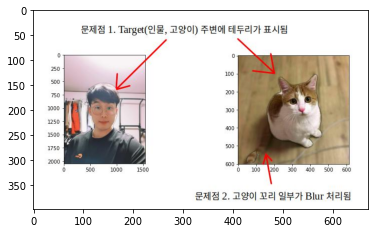

In [21]:
problems_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/problems.jpeg'
problems_orig = cv2.imread(problems_path)
plt.imshow(cv2.cvtColor(problems_orig, cv2.COLOR_BGR2RGB))
plt.show()

### **Step 3. 해결 방법을 제안해 보기**

---

아주 간단히 멋진 카메라앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼만한 주제를 아래에 몇가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.